In [2]:
%matplotlib inline
#%matplotlib notebook
#%matplotlib notebook
import re
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(color_codes=True)

from time import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os; import json; import fileinput
#from numba import jit

In [28]:
st = time()
fileinput.close() # sometimes fileinput is already active

def load_file(filename, transformer=None):
    data_dir = "yelp_dataset_challenge_round9"
    filepath = os.path.join(data_dir, filename)
    max_lines = 250000

    data = []
    for line in fileinput.input(filepath):
        d = json.loads(line)
                
        if transformer:
            d = transformer(d)

        data.append(d)
        if len(data) > max_lines: break
            
    fileinput.close()
    return pd.DataFrame(data)

# These functions transform some values for later
def transf_checkin(d):
    d['n_time'] = len(d['time'])
    return d

def transf_review(d):
    d['date'] = datetime.strptime(d['date'], '%Y-%m-%d')
    d['weekday'] = d['date'].weekday()
    return d

def transf_user(d):    
    d['n_friends'] = len(d['friends'])
    d['n_elite'] = len(d['elite'])
    del d['friends']
    del d['elite']
    #del d['compliment_writer'] # are there more than one type?
    return d

df_bus = load_file("yelp_academic_dataset_business.json")
df_checkin = load_file("yelp_academic_dataset_checkin.json", transf_checkin)
df_review = load_file("yelp_academic_dataset_review.json", transf_review)
df_tip = load_file("yelp_academic_dataset_tip.json")
df_user = load_file("yelp_academic_dataset_user.json", transf_user)

def hours_to_matrix(hours):
    mat = np.zeros((7,), dtype=np.int8)
    if hours is None: 
        return mat
    day = 0
    for h in hours:
        length = 0
        rr = re.findall("[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE]\d+)?", h)
        if len(rr):
            length = int(rr[2]) - int(rr[0])
            if length < 0:
                length += 24
                
        if h.startswith('Mon'): day = 0
        if h.startswith('Tue'): day = 1
        if h.startswith('Wed'): day = 2
        if h.startswith('Thu'): day = 3
        if h.startswith('Fri'): day = 4
        if h.startswith('Sat'): day = 5
        if h.startswith('Sun'): day = 6
        mat[day] = length
    return mat

# add attributes columns
# TODO unfinished for "BusinessParking", "GoodForMeal", "Ambience"
def add_attribute_cols(attr):
    s = {}
    if attr is not None:
        for a in attr:
            t = a.split(':')
            if "True" in t[1]:
                s["attr_" + t[0].strip()] = 1
            else:
                s["attr_" + t[0].strip()] = 0
            if "RestaurantsPriceRange2" in a:
                s["attr_RestaurantsPriceRange2"] = int(t[1])
            if "WiFi: free" in a:
                s["attr_WiFi"] = 1
    return pd.Series(s, dtype=np.int8)

df_bus['opening_hours'] = df_bus['hours'].apply(hours_to_matrix)
df_bus = df_bus.merge(df_bus['attributes'].apply(add_attribute_cols).fillna(0, downcast='infer'), left_index=True, right_index=True)
#df_bus = df_bus.fillna(0, downcast='infer')

df_review = df_review.sort_values(['business_id'])

#df_user['friends']
#df_user['elite']
print('Done in {} s'.format(time() - st))

Done in 82.97421312332153 s


In [4]:
# explore dfs here

#df_user[df_user['compliment_writer'] != 'user']
#print(df_bus[df_bus['type'] != 'business'])
#print(df_checkin[df_checkin['type'] != 'checkin'])
df_bus.tail(10)[['opening_hours', 'hours']]

,opening_hours,hours
4991,"[0, 0, 0, 0, 0, 0, 0]",None
4992,"[8, 8, 8, 8, 8, 7, 0]","[Monday 10:0-18:45, Tuesday 10:0-18:45, Wednes..."
4993,"[9, 7, 6, 9, 6, 0, 0]","[Monday 9:0-18:0, Tuesday 9:0-16:0, Wednesday ..."
4994,"[21, 21, 21, 23, 23, 23, 19]","[Monday 5:0-2:0, Tuesday 5:0-2:0, Wednesday 5:..."
4995,"[0, 0, 0, 0, 0, 0, 0]",None
4996,"[13, 13, 13, 13, 13, 11, 11]","[Monday 5:0-18:0, Tuesday 5:0-18:0, Wednesday ..."
4997,"[0, 0, 0, 0, 0, 0, 0]",None
4998,"[0, 0, 0, 0, 0, 0, 0]","[Monday 0:0-0:0, Tuesday 0:0-0:0, Wednesday 0:..."
4999,"[0, 0, 0, 0, 0, 0, 0]",None
5000,"[0, 8, 8, 8, 6, 6, 0]","[Tuesday 8:0-16:0, Wednesday 8:0-16:0, Thursda..."


In [5]:
# Memory optimization
# Technical stuff, contributes nothing to analysis
for df in [df_bus, df_checkin, df_review, df_tip, df_user]:
    conv = df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
    df[conv.columns] = conv

# Show memory usage
#print(df_bus.info(memory_usage='deep'))

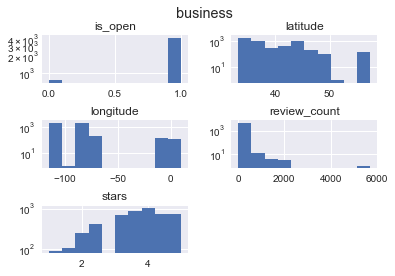

In [6]:
cols = ['review_count', 'stars', 'is_open', 'latitude', 'longitude']
axes = df_bus.hist(column=cols)
for i in axes:
    for ax in i:
        ax.set_yscale('log')

plt.subplots_adjust(hspace=0.8)
plt.suptitle('business')
plt.show()

# business per city
#v = df_bus.groupby('city').size()#.value_counts()
#print(v)
#sns.lmplot('latitude', 'longitude', data=df_bus, fit_reg=False)
#ax = sns.barplot(x=np.array(v.keys()), y=v.values, palette="BuGn_d")
#ax.set_yscale('log') 


In [7]:
import gmaps
from api import api
gmaps.configure(api_key=api)
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(df_bus[['latitude', 'longitude']])
fig.add_layer(heatmap_layer)
#fig

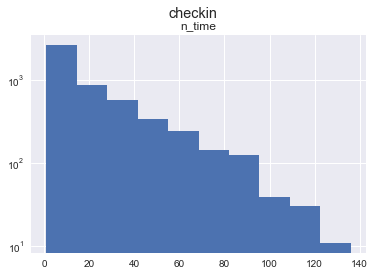

In [8]:
cols = ['n_time']
axes = df_checkin.hist(column=cols)
for i in axes:
    for ax in i:
        ax.set_yscale('log')

plt.subplots_adjust(hspace=0.8)
plt.suptitle('checkin')
plt.show()

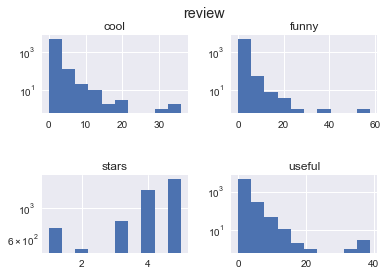

In [9]:
cols = ['stars', 'cool', 'funny', 'useful']
axes = df_review.hist(column=cols)
for i in axes:
    for ax in i:
        ax.set_yscale('log')

plt.subplots_adjust(hspace=0.8)
plt.suptitle('review')
plt.show()

# reviews per user: see under user
# reviews per business: see under business

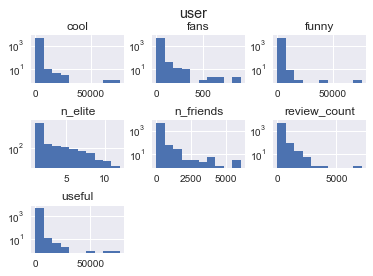

In [10]:
cols = ['review_count', 'n_friends', 'useful', 'funny', 'cool', 'fans', 'n_elite', 'type']
axes = df_user.hist(column=cols)
for i in axes:
    for ax in i:
        ax.set_yscale('log')

plt.subplots_adjust(hspace=0.8)
plt.suptitle('user')
plt.show()

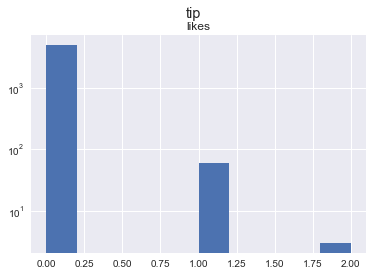

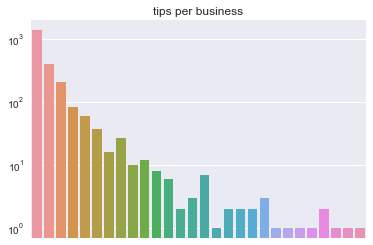

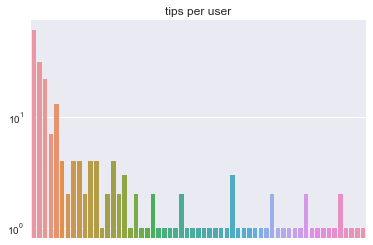

In [11]:
cols = ['likes']
axes = df_tip.hist(column=cols)
for i in axes:
    for ax in i:
        ax.set_yscale('log')

plt.subplots_adjust(hspace=0.8)
plt.suptitle('tip')
plt.show()

# Tips per business
t = df_tip.groupby('business_id').size().value_counts()
ax = sns.barplot(x=np.array(t.keys()), y=t.values)
ax.set_yscale('log')
ax.xaxis.set_ticklabels([])
plt.title('tips per business')
plt.show()

# Tips per user
t = df_tip.groupby('user_id').size().value_counts()
ax = sns.barplot(x=np.array(t.keys()), y=t.values)
ax.set_yscale('log')
ax.xaxis.set_ticklabels([])
plt.title('tips per user')
plt.show()

## Questions
How well can you guess a review's rating from its text alone? Can you take all of the reviews of a business and predict when it will be the most busy, or when the business is open? Can you predict if a business is good for kids? Has WiFi? Has Parking? What makes a review useful, funny, or cool? Can you figure out which business a user is likely to review next? How much of a business's success is really just location, location, location? What businesses deserve their own subcategory (i.e., Szechuan or Hunan versus just “Chinese restaurants”), and can you learn this from the review text? What are the differences between the cities in the dataset?

Can you take all of the reviews of a business and predict when it will be the most busy, or when the business is open?

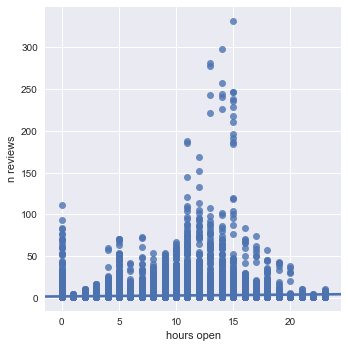

,weekday,n_reviews,hours_open,open
weekday,1.000000,-0.001079,-0.076419,-0.061615
n_reviews,-0.001079,1.000000,0.112040,0.095011
hours_open,-0.076419,0.112040,1.000000,0.909421
open,-0.061615,0.095011,0.909421,1.000000


In [29]:
# prepare data
reviews = df_review.groupby(['business_id', 'weekday']).size().to_frame('n_reviews').reset_index()
reviews = reviews.merge(df_bus[['business_id', 'opening_hours']])
reviews['hours_open'] = reviews.apply(lambda x: x['opening_hours'][x['weekday']], axis=1)    
def is_open(hours):
    if hours > 0: return 1
    else: return 0
reviews['open'] = reviews['hours_open'].apply(is_open)

sns.lmplot('hours_open', 'n_reviews', data=reviews,
           fit_reg=True)
plt.xlabel('hours open')
plt.ylabel('n reviews')
plt.show()

reviews.corr()
#reviews.groupby('open').size()

In [ ]:
# split data
X = reviews[['weekday', 'n_reviews']]
y = reviews['hours_open']

print('Data prepared. Rows: {}'.format(len(X)))
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)        

# train model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, explained_variance_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor

model = Pipeline([
    ('scaler', StandardScaler()),
#    ('learner', LogisticRegression())
#    ('classifier', MLPClassifier())
    ('regressor', MLPRegressor())
])

#print(y_train)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("R^2: %1.3f" % r2_score(y_test, y_pred))
print("Explained var: {:3f}".format(explained_variance_score(y_test, y_pred)))
print(y_pred)
#print(classification_report(y_test, y_pred))

print(grid.best_estimator_.named_steps['regressor'])
if False:
    from sklearn.model_selection import GridSearchCV
    print('Start cv grid search...')
    params = {
        'regressor__hidden_layer_sizes': [(100,), (100, 100), (100, 50)],
        'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    }

    grid = GridSearchCV(model, cv=3, n_jobs=-1, param_grid=params)
    grid.fit(X_train, y_train)
    
    print(grid.best_estimator_named_steps.named_steps['regressor'])
# overfitting
# not enough data to train, better performance needed
# data needs sampling
# a model for every day or multiple regression?

Data prepared. Rows: 110686


Can you predict if a business is good for kids? Has WiFi? Has Parking?

In [15]:
def count_parking(attr):
    counter = 0
    park = [i for i in attr if i.startswith('BusinessParking')]

    if len(park)>0:
        # better than parsing json?
        for a in ["'garage': True", "'street': True", "'lot': True", "'valet': True"]:
            if a in park[0]:
                counter += 1

    return counter

x_cols = ['review_count', 'stars', 'latitude', 'longitude', 'attr_WheelchairAccessible', 'attr_Smoking', 'attr_RestaurantsGoodForGroups']
for i, row in df_bus.iterrows():
    if not row['attributes']: continue
    # X
    
    
    # y
    parking_counter = count_parking(row['attributes'])
    
    if i>10: break
        
        
# split data
# train model
        
df_bus.head(3)#['hours'].values

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,...,attr_RestaurantsCounterService,attr_RestaurantsDelivery,attr_RestaurantsGoodForGroups,attr_RestaurantsPriceRange2,attr_RestaurantsReservations,attr_RestaurantsTableService,attr_RestaurantsTakeOut,attr_Smoking,attr_WheelchairAccessible,attr_WiFi
0,"227 E Baseline Rd, Ste J2","[BikeParking: True, BusinessAcceptsBitcoin: Fa...",0DI8Dt2PJp07XkVvIElIcQ,"[Tobacco Shops, Nightlife, Vape Shops, Shopping]",Tempe,"[Monday 11:0-21:0, Tuesday 11:0-21:0, Wednesda...",0,33.378214,-111.936102,Innovative Vapors,...,0,0,0,2,0,0,0,0,1,0
1,495 S Grand Central Pkwy,"[BusinessAcceptsBitcoin: False, BusinessAccept...",LTlCaCGZE14GuaUXUGbamg,"[Caterers, Grocery, Food, Event Planning & Ser...",Las Vegas,"[Monday 0:0-0:0, Tuesday 0:0-0:0, Wednesday 0:...",1,36.192284,-115.159272,Cut and Taste,...,0,0,0,0,0,0,0,0,0,0
2,979 Bloor Street W,"[Alcohol: none, Ambience: {'romantic': False, ...",EDqCEAGXVGCH4FJXgqtjqg,"[Restaurants, Pizza, Chicken Wings, Italian]",Toronto,"[Monday 11:0-2:0, Tuesday 11:0-2:0, Wednesday ...",1,43.661054,-79.429089,Pizza Pizza,...,0,1,1,1,0,0,1,0,0,1
